# Precificação de Carros

Pedro Araújo Pietrafesa

# Objetivo 

Explique como você faria a previsão do preço a partir dos dados. Quais variáveis e/ou suas transformações você utilizou e por quê? Qual tipo de problema estamos resolvendo (regressão, classificação)? Qual modelo melhor se aproxima dos dados e quais seus prós e contras? Qual medida de performance do modelo foi escolhida e por quê?


A empresa do cliente trabalha com compra e venda de veículos usados e estão com dificuldade na área de revenda dos usados. Para solucionar o problema do negócio, o cliente comprou uma base de dados com informações de anuncios de venda de veículos de 25 estados brasileiros com 28 características que englobam aspectos dos carros, dos donos e de documentação. Há ainda, a variável resposta (_target_) com os preços dos carros.

O objetivo é criar um modelo preditivo que precifique os carros do cliente. Para resolver o problema vamos aplicar um **modelo de regressão**.







# Bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import category_encoders as ce

from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
from sklearn.metrics import r2_score,mean_squared_error


from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,SelectPercentile,f_classif,f_regression,mutual_info_regression,mutual_info_classif,SelectFromModel,RFE

from xgboost import XGBRegressor
from xgboost import plot_importance

# Importando a base de dados

In [43]:
#treino = pd.read_csv('cars_train.csv')
#teste = pd.read_csv('cars_test.csv')


treino = pd.read_csv('https://raw.githubusercontent.com/pedropietrafesa/lighthouse_desafio/main/cars_train.csv')
teste = pd.read_csv('https://raw.githubusercontent.com/pedropietrafesa/lighthouse_desafio/main/cars_test.csv')

pd.set_option('display.max_row', 100)

# Selecionando as variáveis

## Variáveis com dados faltantes

In [5]:
print(" \n Total de dados faltantes em cada coluna do dataset de treino: \n\n",
      treino.isnull().sum().sort_values(ascending = False))

 
 Total de dados faltantes em cada coluna do dataset de treino: 

 veiculo_alienado           29584
garantia_de_fábrica        25219
revisoes_dentro_agenda     23674
revisoes_concessionaria    20412
veiculo_único_dono         19161
veiculo_licenciado         13678
ipva_pago                   9925
dono_aceita_troca           7662
num_fotos                    177
id                             0
estado_vendedor                0
elegivel_revisao               0
troca                          0
entrega_delivery               0
anunciante                     0
cidade_vendedor                0
tipo_vendedor                  0
cor                            0
blindado                       0
tipo                           0
num_portas                     0
cambio                         0
hodometro                      0
ano_modelo                     0
ano_de_fabricacao              0
versao                         0
modelo                         0
marca                          0
preco   

<AxesSubplot:>

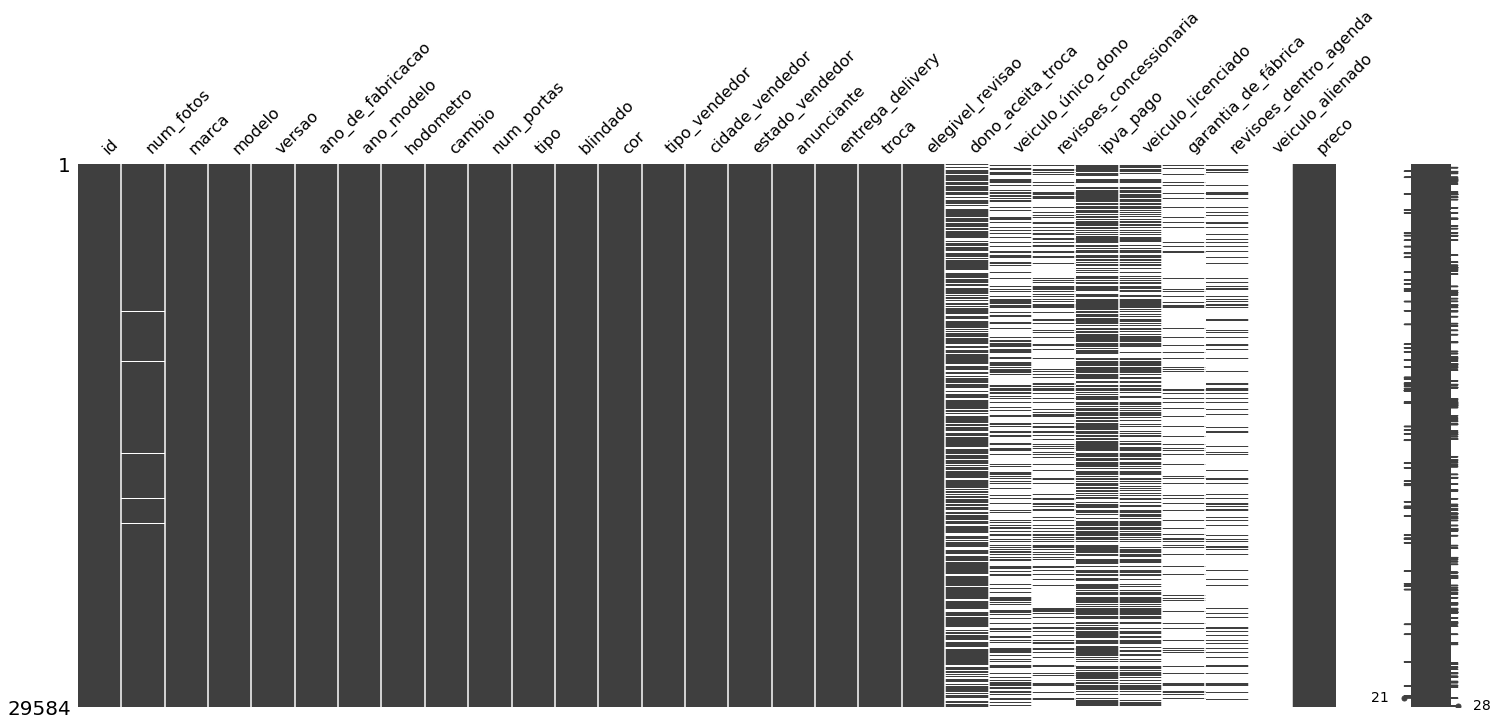

In [6]:
msno.matrix(treino)

Os dados faltantes  pode ocasionar diferentes problemas, como diminuição do desempenho da modelagem e resultados tendenciosos. Assim, as variáveis com mais de 20% de linhas sem informação serão excluídas do modelo, são elas:

* dono_aceita_troca;
* veiculo_único_dono;
* revisoes_concessionaria;
* ipva_pago;
* veiculo_licenciado;
* garantia_de_fábrica;
* revisoes_dentro_agenda;
* veiculo_alienado.




A variável número de fotos também não entrará no modelo. Durante a etapa de análise exploratória dos dados verificou-se que não possui correlação nenhuma com a _Target_. Com isso, do banco de dados, temos 18 variáveis que farão parte do modelo. 

Destas 18 variáveis, apenas 3 não sofrerão algum tipo de transofrmação, seja numa variável _dummy_, seja na diminuição das dimensões. 

In [4]:
# Cirando uma nova base de dados sem as variáveis com mais de 25% de dados faltantes
treino1 = treino.drop(columns=['num_fotos','elegivel_revisao','dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago',
                      'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda',
                      'veiculo_alienado'], axis=1)

### Ajustando as variáveis categóricas do dataset que estão no formato booleano

In [5]:
treino1.loc[ treino1["entrega_delivery"] == False, "entrega_delivery"] = "Não"
treino1.loc[ treino1["entrega_delivery"] == True, "entrega_delivery"] = "Sim"
treino1.loc[ treino1["troca"] == False, "troca"] = "Não"
treino1.loc[ treino1["troca"] == True, "troca"] = "Sim"
treino1.loc[ treino1["blindado"] == "N", "blindado"] = "Não"
treino1.loc[ treino1["blindado"] == "S", "blindado"] = "Sim"

## Dividindo o Banco de Dados de Treino em Dois: treino e validação

In [170]:
treino1.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29584 entries, 0 to 29583
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 29584 non-null  object 
 1   marca              29584 non-null  object 
 2   modelo             29584 non-null  object 
 3   versao             29584 non-null  object 
 4   ano_de_fabricacao  29584 non-null  int64  
 5   ano_modelo         29584 non-null  int64  
 6   hodometro          29584 non-null  int64  
 7   cambio             29584 non-null  object 
 8   num_portas         29584 non-null  int64  
 9   tipo               29584 non-null  object 
 10  blindado           29584 non-null  object 
 11  cor                29584 non-null  object 
 12  tipo_vendedor      29584 non-null  object 
 13  cidade_vendedor    29584 non-null  object 
 14  estado_vendedor    29584 non-null  object 
 15  anunciante         29584 non-null  object 
 16  entrega_delivery   295

In [6]:
X = treino1.iloc[:,1:18]
Y = treino1[['preco']]


[X_treino, X_val, y_treino, y_val] = train_test_split(X, Y, test_size=0.3, random_state=2023)

## Transformação das Variáveis categóricas

### Transformação das variáveis categóricas usando os _encoders_

As variáveis com até sete categorias serão transformadas utilizando o _encoder_ chamado _One Hot Encoder_ que retornará as variáveis na forma de dummies com a coluna indicando 0 ou 1. As demais por emio do _encoder_ James-Stein Encoding.

#### One Hot Encoder

In [7]:
enc = ce.OneHotEncoder(cols=['cambio','tipo','blindado', 'cor', 'tipo_vendedor',
                            'anunciante', 'entrega_delivery','troca']) 


enc.fit(X_treino)
enc.fit(X_val)

OneHotEncoder(cols=['cambio', 'tipo', 'blindado', 'cor', 'tipo_vendedor',
                    'anunciante', 'entrega_delivery', 'troca'])

In [8]:
X_treino = enc.transform(X_treino)
X_val = enc.transform(X_val)

In [204]:
X_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20708 entries, 558 to 21335
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   marca               20708 non-null  float64
 1   modelo              20708 non-null  float64
 2   versao              20708 non-null  float64
 3   ano_de_fabricacao   20708 non-null  int64  
 4   ano_modelo          20708 non-null  int64  
 5   hodometro           20708 non-null  int64  
 6   cambio_1            20708 non-null  int64  
 7   cambio_2            20708 non-null  int64  
 8   cambio_3            20708 non-null  int64  
 9   cambio_4            20708 non-null  int64  
 10  cambio_5            20708 non-null  int64  
 11  cambio_6            20708 non-null  int64  
 12  cambio_7            20708 non-null  int64  
 13  num_portas          20708 non-null  int64  
 14  tipo_1              20708 non-null  int64  
 15  tipo_2              20708 non-null  int64  
 16  ti

#### James-Stein Encoding

In [31]:
enc = ce.JamesSteinEncoder(cols=['estado_vendedor','cidade_vendedor','versao', 'modelo', 'marca'])

enc.fit(X_treino, y_treino)
enc.fit(X_val, y_val)
X_treino = enc.transform(X_treino)
X_val = enc.transform(X_val)


In [206]:
X_treino.describe()

,marca,modelo,versao,ano_de_fabricacao,ano_modelo,hodometro,cambio_1,cambio_2,cambio_3,cambio_4,...,tipo_vendedor_2,cidade_vendedor,estado_vendedor,anunciante_1,anunciante_2,anunciante_3,entrega_delivery_1,entrega_delivery_2,troca_1,troca_2
count,20708.000000,20708.000000,2.070800e+04,20708.000000,20708.000000,20708.000000,20708.000000,20708.000000,20708.000000,20708.000000,...,20708.000000,2.070800e+04,20708.000000,20708.000000,20708.000000,20708.000000,20708.000000,20708.000000,20708.000000,20708.000000
mean,128431.778528,124948.806096,1.269044e+05,2016.751207,2017.793558,58530.410131,0.167133,0.763232,0.060991,0.004732,...,0.394147,1.323212e+05,133695.038827,0.608026,0.333301,0.058480,0.796745,0.203255,0.827651,0.172349
std,24325.612629,39349.651944,5.346417e+04,4.034874,2.666800,32546.273520,0.373104,0.425109,0.239319,0.068632,...,0.488679,2.131591e+04,5280.215309,0.488203,0.471405,0.234654,0.402430,0.402430,0.377692,0.377692
min,51181.155785,25806.174465,1.990636e+04,1985.000000,2006.000000,100.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,3.029368e+04,60637.716360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,107966.908110,93728.440860,8.683907e+04,2015.000000,2016.000000,31316.750000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.308283e+05,131898.950765,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,124232.534147,127172.713497,1.270922e+05,2018.000000,2018.000000,57656.500000,0.000000,1.000000,0.000000,0.000000,...,0.000000,1.337645e+05,131898.950765,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,144983.175209,150015.459048,1.518377e+05,2019.000000,2020.000000,81953.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.378787e+05,135627.283413,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,442765.729100,450442.093900,1.349748e+06,2022.000000,2023.000000,390065.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.359813e+06,167471.686873,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Testando os modelos

### Testando o modelo base de Regressão Linear

In [10]:
m1 = LinearRegression()

In [11]:
m1.fit(X_treino, y_treino)

LinearRegression()

In [12]:
y_pred = m1.predict(X_val)

print (f'modelo : {m1} e o score do rmse é : {np.sqrt(mean_squared_error(y_val, y_pred))}, o score do r2 é {r2_score(y_val, y_pred)}')

modelo : LinearRegression() e o score do rmse é : 45676.08330925364, o score do r2 é 0.6974470425007748


### Testando Modelos de Machine Learning 

In [13]:
rmse_test =[]
r2_test =[]
nomes_modelos =[]

rf = RandomForestRegressor(random_state=2023)
gb = GradientBoostingRegressor(random_state=2023)
et= ExtraTreesRegressor(random_state=2023)
xgb = XGBRegressor(random_state=2023)

modelos = [rf,gb,et,xgb]

for model in modelos:
    model.fit(X_treino, y_treino)
    y_pred = model.predict(X_val)
    rmse_test.append(round(np.sqrt(mean_squared_error(y_val, y_pred)),2))
    r2_test.append(round(r2_score(y_val, y_pred),2))
    print (f'model : {model} e o score rmse é : {round(np.sqrt(mean_squared_error(y_val, y_pred)),2)}, o score r2 é {round(r2_score(y_val, y_pred),4)}')

nomes_modelos = ['RandomForest','GradientBoost','ExtraTree','XGB']
resultado_df = pd.DataFrame({'RMSE':rmse_test,'R2':r2_test}, index=nomes_modelos)
resultado_df

/Users/pedropietrafesa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model : RandomForestRegressor(random_state=2023) e o score rmse é : 42590.82, o score r2 é 0.7369


/Users/pedropietrafesa/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model : GradientBoostingRegressor(random_state=2023) e o score rmse é : 43019.29, o score r2 é 0.7316


/Users/pedropietrafesa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model : ExtraTreesRegressor(random_state=2023) e o score rmse é : 43599.24, o score r2 é 0.7243
model : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2023, ...) e o score rmse é : 42437.58, o score r2 é 0.7388


,RMSE,R2
RandomForest,42590.82,0.74
GradientBoost,43019.29,0.73
ExtraTree,43599.24,0.72
XGB,42437.58,0.74


/Users/pedropietrafesa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


 rmse score is : 42628.5186, r2 score is 0.7365


#### Aplicando Tuning nos modelos de Machine Learning

In [16]:
rmse_test =[]
r2_test =[]
nomes_modelos =[]

rf = RandomForestRegressor(n_estimators = 100,
                           min_samples_split = 6,
                           min_samples_leaf= 4,
                           max_features = 'sqrt',
                           max_depth= 120,
                           bootstrap=False,
                           random_state=2023)


gb = GradientBoostingRegressor(learning_rate=0.1,
                               min_samples_split=500,
                               min_samples_leaf=50,
                               max_depth=8,
                               max_features='sqrt',
                               subsample=0.8,
                               random_state=2023)


et= ExtraTreesRegressor(n_estimators=1000,
                        max_features=5,
                        min_samples_split=3,
                        random_state=2023)

xgb = XGBRegressor(learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 scale_pos_weight=1,
 random_state=2023)


modelos = [rf,gb,et,xgb]

for model in modelos:
    model.fit(X_treino, y_treino)
    y_pred = model.predict(X_val)
    rmse_test.append(round(np.sqrt(mean_squared_error(y_val, y_pred)),2))
    r2_test.append(round(r2_score(y_val, y_pred),2))
    print (f'model : {model} e o score rmse é : {round(np.sqrt(mean_squared_error(y_val, y_pred)),2)}, o score r2 é {round(r2_score(y_val, y_pred),4)}')

nomes_modelos = ['RandomForest','GradientBoost','ExtraTree','XGB']
resultado_df = pd.DataFrame({'RMSE':rmse_test,'R2':r2_test}, index=nomes_modelos)
resultado_df

/Users/pedropietrafesa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model : RandomForestRegressor(bootstrap=False, max_depth=120, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=6,
                      random_state=2023) e o score rmse é : 42444.71, o score r2 é 0.7387


/Users/pedropietrafesa/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


model : GradientBoostingRegressor(max_depth=8, max_features='sqrt', min_samples_leaf=50,
                          min_samples_split=500, random_state=2023,
                          subsample=0.8) e o score rmse é : 42491.98, o score r2 é 0.7382


/Users/pedropietrafesa/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


model : ExtraTreesRegressor(max_features=5, min_samples_split=3, n_estimators=1000,
                    random_state=2023) e o score rmse é : 44427.15, o score r2 é 0.7138
model : XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=2023, ...) e o score rmse é : 41930.47, o score r2 é 0.745


,RMSE,R2
RandomForest,42444.71,0.74
GradientBoost,42491.98,0.74
ExtraTree,44427.15,0.71
XGB,41930.47,0.75


O modelo selecionado foi o XGBoostque apresentou o melhor R2 e o menor Erro Quadrático Médio.

## Predição

In [67]:
teste1 = teste.drop(columns=['id','num_fotos','elegivel_revisao','dono_aceita_troca', 'veiculo_único_dono', 'revisoes_concessionaria', 'ipva_pago',
                      'veiculo_licenciado', 'garantia_de_fábrica', 'revisoes_dentro_agenda',
                      'veiculo_alienado'], axis=1)

In [68]:
teste1.loc[ teste1["entrega_delivery"] == False, "entrega_delivery"] = "Não"
teste1.loc[ teste1["entrega_delivery"] == True, "entrega_delivery"] = "Sim"
teste1.loc[ teste1["troca"] == False, "troca"] = "Não"
teste1.loc[ teste1["troca"] == True, "troca"] = "Sim"
teste1.loc[ teste1["blindado"] == "N", "blindado"] = "Não"
teste1.loc[ teste1["blindado"] == "S", "blindado"] = "Sim"


In [69]:
enc = ce.OneHotEncoder(cols=['cambio','tipo','blindado', 'cor', 'tipo_vendedor',
                            'anunciante', 'entrega_delivery','troca']) 


enc.fit(teste1)
teste1 = enc.transform(teste1)
teste1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9862 entries, 0 to 9861
Data columns (total 42 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   marca               9862 non-null   object
 1   modelo              9862 non-null   object
 2   versao              9862 non-null   object
 3   ano_de_fabricacao   9862 non-null   int64 
 4   ano_modelo          9862 non-null   int64 
 5   hodometro           9862 non-null   int64 
 6   cambio_1            9862 non-null   int64 
 7   cambio_2            9862 non-null   int64 
 8   cambio_3            9862 non-null   int64 
 9   cambio_4            9862 non-null   int64 
 10  cambio_5            9862 non-null   int64 
 11  cambio_6            9862 non-null   int64 
 12  cambio_7            9862 non-null   int64 
 13  num_portas          9862 non-null   int64 
 14  tipo_1              9862 non-null   int64 
 15  tipo_2              9862 non-null   int64 
 16  tipo_3              9862

In [70]:
teste1 = teste1.drop(columns=['tipo_8', 'anunciante_4'], axis=1)

In [71]:
enc1 = ce.JamesSteinEncoder(cols=['estado_vendedor','cidade_vendedor','versao', 'modelo', 'marca'])
enc1.fit(X_val, y_val)

teste1 = enc1.transform(teste1)

In [99]:
y_pred = pd.DataFrame(xgb.predict(teste1))

In [100]:
predicao = pd.DataFrame(teste['id'])

In [101]:
### Reorganizando a base de dados
y_pred = y_pred.rename(columns={y_pred.columns[0]: 'preco'})

y_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9862 entries, 0 to 9861
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preco   9862 non-null   float32
dtypes: float32(1)
memory usage: 38.6 KB


In [102]:
predicao.insert(1, "preco", y_pred)


predicao.head()

,id,preco
0,13518783164498355150900635905895481162,206589.625000
1,299896161723793383246777788797566040330,175082.671875
2,316180649972302128246133616457018378621,148410.468750
3,222527157104148385909188217274642813298,186174.015625
4,160460343059850745858546502614838368036,178965.359375


In [103]:
predicao.to_csv('predicted.csv')